In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


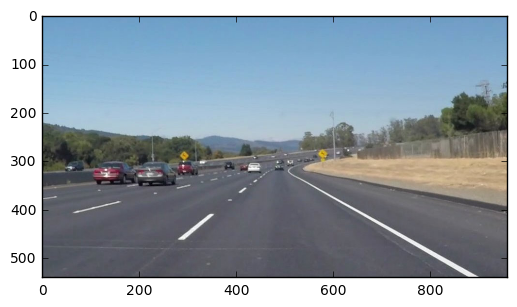

In [2]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def make_vertices(img):
    """getting points of area interested in
    """
    import numpy as np
    img_shape = img.shape
    
    upper_left = (int(0.4*img_shape[1]), int(0.65*img_shape[0]))
    upper_right = (int(0.6*img_shape[1]), int(0.65*img_shape[0]))
    
    return np.array([[(0,img_shape[0]),upper_left, upper_right, (img_shape[1],img_shape[0])]], dtype=np.int32)
    

def remove_outlier(fit_list):
    """
    remove outliers with confidence interval(90%)
    """
    
    #For efficient computation, use numpy array
    reshape_list = np.array(fit_list).reshape(-1,2)
    mean_value = np.mean(reshape_list, axis=0)
    subst_mean = np.subtract(reshape_list, mean_value)
    square = np.square(subst_mean)
    # standard deviation
    std = np.sqrt(np.sum(square, axis=0)/(len(fit_list)-1))
    # 90% confidence interval(90%)
    plus, minus = mean_value+std*1.645, mean_value-std*1.645
    
    # remove elements in outside interval
    reshape_list = reshape_list[(minus[0]< reshape_list[:,0]) & (reshape_list[:,0]< plus[0])]
    reshape_list = reshape_list[(minus[1]< reshape_list[:,1]) & (reshape_list[:,1]< plus[1])]
    fit_list = list(reshape_list)
    return fit_list

    
def smooth_fit(fit_list, data, keep_frame=50):
    """
    accumulate data of lanes and make average of it to get changing of lines smoothly
    """
    import numpy as np
    #print("길이는--->", len(fit_list))
    
    if(len(fit_list) > 30):
        if(len(fit_list) == keep_frame):
            fit_list.pop(0) # pop the first element of list
        if(data is not None):
            fit_list.append(data)
            
        fit_list = remove_outlier(fit_list)
        #print("통과된 길이-->", len(fit_list))
        #print("계산된--->", np.mean(fit_list, axis=0))
        return np.mean(fit_list, axis=0)
    else:    
        if(len(fit_list) == keep_frame):
            fit_list.pop(0) # pop the first element of list
        if(data is not None):
            fit_list.append(data)
        return np.mean(fit_list, axis=0)

    
def before_momentum():
    """
    reset all of global variables used in function, 'draw_lines'
    """
    global momentum_left_fit
    global momentum_right_fit
    global fit_left
    global fit_right
    global momentum_left
    global momentum_right
    
    momentum_left_fit = []
    momentum_right_fit = []
    fit_left =[]
    fit_right =[]
    momentum_left = []
    momentum_right = []

def draw_lines(img, lines, color=[255, 255, 255], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_under_x = []
    right_under_y = []
    right_upper_x = []
    right_upper_y = []
    
    left_under_x = []
    left_under_y = []
    left_upper_x = []
    left_upper_y = []
    
    if lines is None:
        cv2.line(img, momentum_left[0], momentum_left[1], [0,0,255], thickness)
        cv2.line(img, momentum_right[0], momentum_right[1], [0,0,255], thickness)
    
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                
                cv2.line(img, (x1, y1), (x2, y2), [255,0,0], 2)
                
                if(slope < -0.5):
                    # These points are left lanes
                    # print("left!--->", x1,y1,x2,y2)
                    left_under_x.append(x1)
                    left_under_y.append(y1)

                    left_upper_x.append(x2)
                    left_upper_y.append(y2)
                    cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 3)
                elif(slope > 0.5):
                    # These points are right lanes
                    #print("right!--->", x1,y1,x2,y2)
                    right_under_x.append(x1)
                    right_under_y.append(y1)

                    right_upper_x.append(x2)
                    right_upper_y.append(y2)
                    cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 3)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

        #print('length of right points--->', len(right_under_x))
        #print('length of left points--->', len(left_under_x))
        
        # calculate mean valude of points in left lanes
        mean_left_under_x = np.median(left_under_x)
        mean_left_under_y = np.median(left_under_y)
        mean_left_upper_x = np.median(left_upper_x)
        mean_left_upper_y = np.median(left_upper_y)
        
        # calculate mean valude of points in right lanes
        mean_right_under_x = np.median(right_under_x)
        mean_right_under_y = np.median(right_under_y)
        mean_right_upper_x = np.median(right_upper_x)
        mean_right_upper_y = np.median(right_upper_y)
  

        # calculate slope and y-intercept of lanes
        if(len(left_under_x) >= 2):
            global fit_left
            fit_left = np.polyfit((mean_left_under_x, mean_left_upper_x), (mean_left_under_y, mean_left_upper_y), 1)
        if(len(right_under_x) >= 2):
            global fit_right
            fit_right = np.polyfit((mean_right_under_x, mean_right_upper_x), (mean_right_under_y, mean_right_upper_y), 1)

        #print("fit_left-->", fit_left)
        #print("fit_right-->", fit_right)
        
        # 4 points of area where we are interested in
        vertices = make_vertices(img)
        upper_left, upper_right = vertices[0][1], vertices[0][2]
        
        # before smoothing
        left_bottom_x = int((img.shape[0]-fit_left[1])/fit_left[0])
        right_bottom_x = int((img.shape[0]-fit_right[1])/fit_right[0])
        left_upper_x = int((upper_left[1]-fit_left[1])/fit_left[0])
        right_upper_x = int((upper_right[1]-fit_right[1])/fit_right[0])
        
        cv2.line(img, (left_bottom_x, img.shape[0]), (left_upper_x, int(upper_left[1])), [0,255,255], 5)
        cv2.line(img, (right_bottom_x, img.shape[0]), (right_upper_x, int(upper_right[1])), [0,255,255], 5)
        
        # after smoothing
        
        global momentum_left_fit
        global momentum_right_fit
        fit_left = smooth_fit(momentum_left_fit, fit_left)
        fit_right = smooth_fit(momentum_right_fit, fit_right)
        

        # To get longer lanes, We calculate intersection points between interesting area
        # and lanes which are based on mean of points above we find.
        # y = ax + b -> x = (y-b)/a
        left_bottom_x = int((img.shape[0]-fit_left[1])/fit_left[0])
        right_bottom_x = int((img.shape[0]-fit_right[1])/fit_right[0])

        left_upper_x = int((upper_left[1]-fit_left[1])/fit_left[0])
        right_upper_x = int((upper_right[1]-fit_right[1])/fit_right[0])

        global momentum_left
        global momentum_right
        momentum_left = [(left_bottom_x, img.shape[0]), (left_upper_x, int(upper_left[1]))]
        momentum_right = [(right_bottom_x, img.shape[0]), (right_upper_x, int(upper_right[1]))]

        cv2.line(img, (left_bottom_x, img.shape[0]), (left_upper_x, int(upper_left[1])), color, thickness)
        cv2.line(img, (right_bottom_x, img.shape[0]), (right_upper_x, int(upper_right[1])), color, thickness)

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

<ipython-input-3-e9ed193efa7e>:235: SyntaxWarning: name 'momentum_left' is used prior to global declaration
  global momentum_left
<ipython-input-3-e9ed193efa7e>:236: SyntaxWarning: name 'momentum_right' is used prior to global declaration
  global momentum_right


### Before showing whole process, I'm going to show ways of finding lanes stage by stage

## 1. Apply a Gaussian Noise, before the Canny transform

It makes it easy to find lines smoothing values of pixels in image.

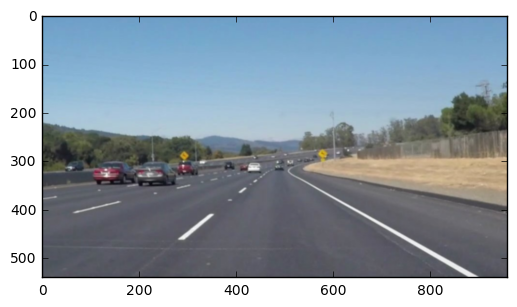

In [4]:
blur_image = gaussian_blur(image, 5) # kernel size = 5
plt.imshow(blur_image)

## 2. Apply Canny transform to find line candidates

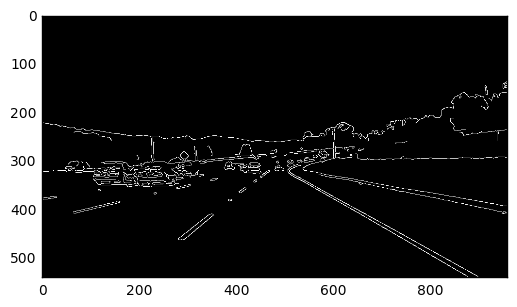

In [5]:
low_threshold = 50
high_threshold = 150
edges = canny(blur_image, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

## 3. Masking out area we don't interested in

In [6]:
vertices = make_vertices(edges)
vertices

array([[[  0, 540],
        [384, 351],
        [576, 351],
        [960, 540]]], dtype=int32)

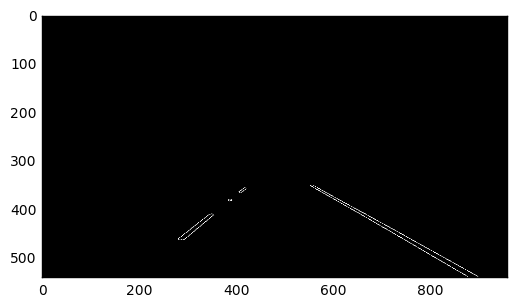

In [7]:
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges, cmap='gray')

## 4. Getting Lines

### white lane is final result

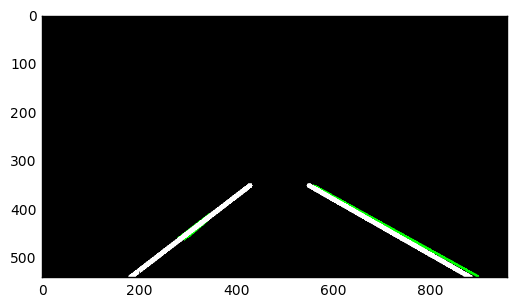

In [8]:
before_momentum()
line_img = hough_lines(masked_edges, 2, np.pi/180, 15, 40, 20)
plt.imshow(line_img)

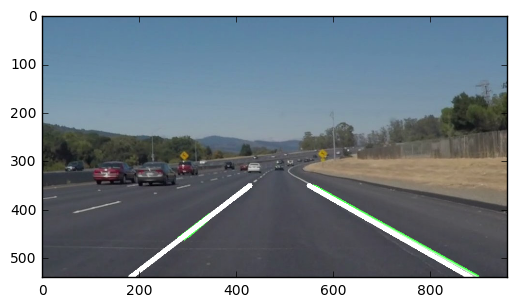

In [9]:
final = weighted_img(line_img, image)
plt.imshow(final)

### Now, I put all process together

In [10]:
def process_image(image):
    
    # 1. Apply a Gaussian Noise, before the Canny transform
    blur_image = gaussian_blur(image, 5)
    
    # 2. Apply Canny transform to find line candidates
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_image, low_threshold, high_threshold)
    
    # 3. Masking out area we don't interested in
    vertices = make_vertices(edges)
    masked_edges = region_of_interest(edges, vertices)
    
    # 4. Getting lines
    line_img = hough_lines(masked_edges, 2, np.pi/180, 15, 40, 20)
    
    # final
    result = weighted_img(line_img, image)
    return result

# Test on Images

In [11]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

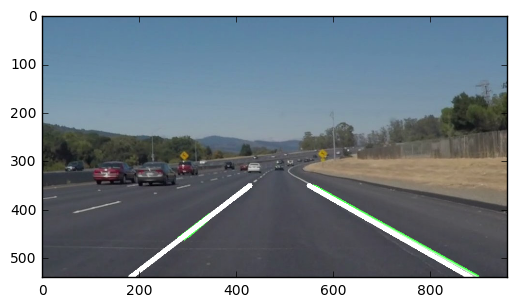

In [12]:
before_momentum()
og_img = mpimg.imread("test_images/"+"solidWhiteCurve.jpg")
result = process_image(og_img)
plt.imshow(result)

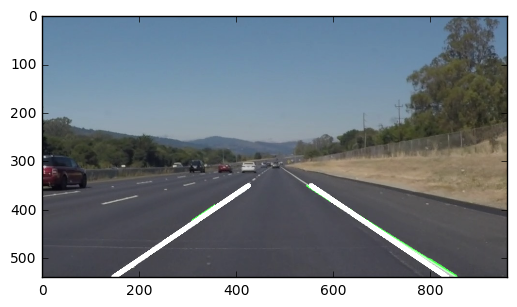

In [13]:
before_momentum()
og_img = mpimg.imread("test_images/"+"solidWhiteRight.jpg")
result = process_image(og_img)
plt.imshow(result)

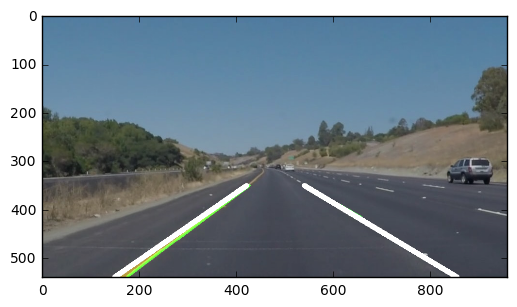

In [14]:
before_momentum()
og_img = mpimg.imread("test_images/"+"solidYellowCurve.jpg")
result = process_image(og_img)
plt.imshow(result)

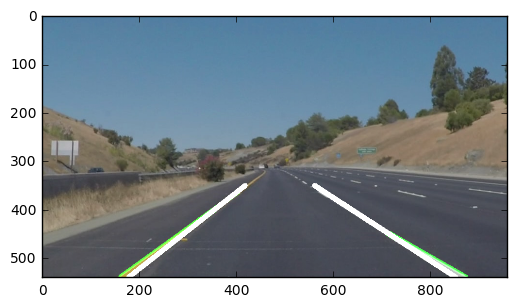

In [15]:
before_momentum()
og_img = mpimg.imread("test_images/"+"solidYellowCurve2.jpg")
result = process_image(og_img)
plt.imshow(result)

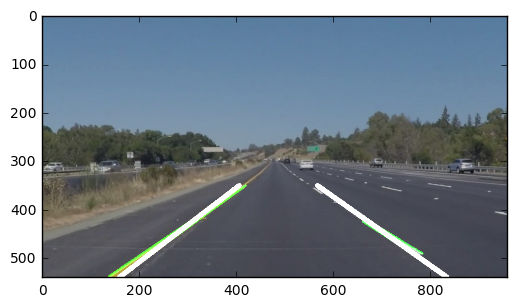

In [16]:
before_momentum()
og_img = mpimg.imread("test_images/"+"solidYellowLeft.jpg")
result = process_image(og_img)
plt.imshow(result)

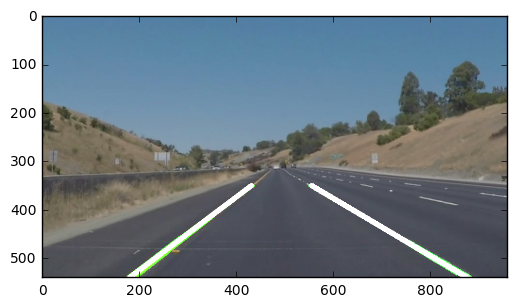

In [17]:
before_momentum()
og_img = mpimg.imread("test_images/"+"whiteCarLaneSwitch.jpg")
result = process_image(og_img)
plt.imshow(result)

### save the outcome images of test

In [18]:
for img_name in os.listdir("test_images/"):
    image = mpimg.imread("test_images/"+img_name)
    before_momentum()
    output = process_image(image)
    output_directory = "test_images_result"
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    mpimg.imsave(output_directory+"/"+img_name, output)
    print("Complete-->test_images/test_images_result/"+img_name)

print("finished")

Complete-->test_images/test_images_result/solidWhiteCurve.jpg
Complete-->test_images/test_images_result/solidWhiteRight.jpg
Complete-->test_images/test_images_result/solidYellowCurve.jpg
Complete-->test_images/test_images_result/solidYellowCurve2.jpg
Complete-->test_images/test_images_result/solidYellowLeft.jpg
Complete-->test_images/test_images_result/whiteCarLaneSwitch.jpg
finished


# Reflections

To make better lane detection algorithms, first of all, I set slope thresholds and filter lines from hough transform with thresholds.(I set line color to red color before filter and green color after filter)

Second, I get lines which values(slope, intercept) is mid of hough lines. This process needs to keep all points from hough lines. Those lines are left side line and right side line.

Third, I calculate four intersection points between two lines and area that shape is trapezoid(from function, 'region_of_interest') to get long lines. Now, we connect upper points and lower points. It will left line and right line. These two lines are result(Color is light blue)

In addition, If we process multiple images(frame) like video, we can make change of lanes smooth using the history of lines because cars move continously. I keep data of lines from frames up to 50 frame and use average values them. The important key thing here is removing outliers to avoid noise with confidence interval(90% I used). As a result, a car can always detect lane lines with recent multiple frame up to 50. lane lines are colored white. Lastly, I make algorithm use the past value in case hough transform do not find any lines. In that case, color of lane lines is blue.

We can check the smoothing effect from below videos.

# Test on Videos

I test solution on two provided videos:

- soldWhiteRight.mp4
- solidYellowLeft.mp4

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
before_momentum()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.33 s, sys: 747 ms, total: 6.08 s
Wall time: 9.45 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
before_momentum()
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:26<00:00, 25.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.3 s, sys: 2.56 s, total: 18.8 s
Wall time: 27.2 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Optional Challenge

In [24]:
before_momentum()

In [25]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 15.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.9 s, sys: 2.15 s, total: 13.1 s
Wall time: 17.8 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))